# NorgesGruppen Grocery Dataset Overview

Welcome to the NorgesGruppen Grocery Dataset! This notebook provides an introduction to the dataset, its structure, and examples of the data it contains.

## 1. About the Dataset

This dataset comprises grocery product images captured at self-checkout registers in a Meny Skøyen store, which is part of the NorgesGruppen retail chain. Each image features a grocery item accompanied by annotation data, including:

- Product identifier (PLU/GTIN)
- Bounding box coordinates
- Image metadata

This dataset is designed for developing computer vision models capable of automatically identifying grocery products during checkout, with potential real-world applications such as:

- Reducing checkout time
- Improving the accuracy of product recognition
- Detecting potential theft or missed scans
- Enhancing the overall shopping experience

Let's explore the dataset's structure and examine some examples!

In [23]:
# Import necessary libraries
import os
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from matplotlib.patches import Rectangle

# Set the dataset path
DATASET_PATH = 'data/'
data_sub_folder = "images/NGD_HACK/"

DATASET_PATH = DATASET_PATH + data_sub_folder

## 2. Folder Structure

The dataset is organized by product identifier (PLU/GTIN). Each product has its own folder containing all instances of that product:

In [24]:
product_folders = sorted([f for f in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, f))])
print(f"Total number of product categories: {len(product_folders)}")
print("\nSample product folders (PLU/GTIN codes):")
print(product_folders[:10])

Total number of product categories: 26

Sample product folders (PLU/GTIN codes):
['4011', '4015', '4088', '4196', '7020097009819', '7020097026113', '7023026089401', '7035620058776', '7037203626563', '7037206100022']


Within each product folder, you'll find three types of files for each instance:

1. **Image file (.png)**: The actual image of the product
2. **Annotation file (.txt)**: JSON file containing bounding box coordinates and metadata
3. **Visualization file (_bb.png)**: Image with bounding box visualization

Let's look at the structure of files for one product:

In [25]:
sample_product = '4011' # Example product code of a banana
sample_files = sorted(os.listdir(os.path.join(DATASET_PATH, sample_product)))[:15]

print(f"Files for product {sample_product} (first 15):")
for f in sample_files:
    print(f"  {f}")

Files for product 4011 (first 15):
  4011-1000.png
  4011-1000.txt
  4011-1000_bb.png
  4011-1005.png
  4011-1005.txt
  4011-1005_bb.png
  4011-1015.png
  4011-1015.txt
  4011-1015_bb.png
  4011-1016.png
  4011-1016.txt
  4011-1016_bb.png
  4011-1020.png
  4011-1020.txt
  4011-1020_bb.png


## 3. PLU/GTIN Mapping

Each product in the dataset is identified by a unique PLU (Price Look-Up) code or GTIN (Global Trade Item Number). Here's the mapping between these codes and product names:

In [26]:
# Create a dictionary mapping PLU/GTIN to product names
plu_mapping = {
    '4011': 'Bananer Bama',
    '4015': 'Epler Røde',
    '4088': 'Paprika Rød',
    '4196': 'Appelsin',
    '94011': 'Bananer Økologisk',
    '90433917': 'Red Bull Regular 250ml boks',
    '90433924': 'Red Bull Sukkerfri 250ml boks',
    '7020097009819': 'Karbonadedeig 5% u/Salt og Vann 400g Meny',
    '7020097026113': 'Kjøttdeig Angus 14% 400g Meny',
    '7023026089401': 'Ruccula 65g Grønn&Frisk',
    '7035620058776': 'Rundstykker Grove Fullkorn m/Frø Rustikk 6stk 420g',
    '7037203626563': 'Leverpostei Ovnsbakt Orginal 190g Gilde',
    '7037206100022': 'Kokt Skinke Ekte 110g Gilde',
    '7038010009457': 'Yoghurt Skogsbær 4x150g Tine',
    '7038010013966': 'Norvegia 26% skivet 150g Tine',
    '7038010021145': 'Jarlsberg 27% skivet 120g Tine',
    '7038010054488': 'Cottage Cheese Mager 2% 400g Tine',
    '7038010068980': 'Yt Protein Yoghurt Vanilje 430g Tine',
    '7039610000318': 'Frokostegg Frittgående L 12stk Prior',
    '7040513000022': 'Gulrot 750g Beger',
    '7040513001753': 'Gulrot 1kg pose First Price',
    '7040913336684': 'Evergood Classic Filtermalt 250g',
    '7044610874661': 'Pepsi Max 0,5l flaske',
    '7048840205868': 'Frokostyoghurt Skogsbær 125g pose Q',
    '7071688004713': 'Original Havsalt 190g Sørlandschips',
    '7622210410337': 'Kvikk Lunsj 3x47g Freia'
}

# Convert to DataFrame and display
plu_df = pd.DataFrame({
    'GTIN/PLU': list(plu_mapping.keys()),
    'Produktnavn': list(plu_mapping.values())
})

# Count number of images per product code
image_counts = {}
for product in product_folders:
    if product in plu_mapping:  # Make sure we only count products in our mapping
        product_path = os.path.join(DATASET_PATH, product)
        # Count only .png files that don't end with _bb.png
        count = len([f for f in os.listdir(product_path) if f.endswith('.png') and not f.endswith('_bb.png')])
        image_counts[product] = count

# Add count to DataFrame
plu_df['Antall bilder'] = plu_df['GTIN/PLU'].map(image_counts).fillna(0).astype(int)

# Display the DataFrame
plu_df.sort_values('Antall bilder', ascending=False)

GTIN/PLU                                        Produktnavn  \
22  7044610874661                              Pepsi Max 0,5l flaske   
1            4015                                         Epler Røde   
3            4196                                           Appelsin   
4           94011                                  Bananer Økologisk   
7   7020097009819          Karbonadedeig 5% u/Salt og Vann 400g Meny   
2            4088                                        Paprika Rød   
17  7038010068980               Yt Protein Yoghurt Vanilje 430g Tine   
12  7037206100022                        Kokt Skinke Ekte 110g Gilde   
14  7038010013966                      Norvegia 26% skivet 150g Tine   
19  7040513000022                                  Gulrot 750g Beger   
6        90433924                      Red Bull Sukkerfri 250ml boks   
16  7038010054488                  Cottage Cheese Mager 2% 400g Tine   
0            4011                                       Bananer Bama   
18  7039610000318               Frokostegg Frittgående L 12stk Prior   
9   7023026089401                            Ruccula 65g Grønn&Frisk   
5        90433917                        Red Bull Regular 250ml boks   
25  7622210410337                            Kvikk Lunsj 3x47g Freia   
21  7040913336684                   Evergood Classic Filtermalt 250g   
15  7038010021145                     Jarlsberg 27% skivet 120g Tine   
13  7038010009457                       Yoghurt Skogsbær 4x150g Tine   
23  7048840205868                Frokostyoghurt Skogsbær 125g pose Q   
8   7020097026113                      Kjøttdeig Angus 14% 400g Meny   
20  7040513001753                        Gulrot 1kg pose First Price   
24  7071688004713                Original Havsalt 190g Sørlandschips   
11  7037203626563            Leverpostei Ovnsbakt Orginal 190g Gilde   
10  7035620058776  Rundstykker Grove Fullkorn m/Frø Rustikk 6stk ...   

    Antall bilder  
22            288  
1             242  
3             237  
4             225  
7             181  
2             175  
17            163  
12            162  
14            161  
19            138  
6             135  
16            120  
0             117  
18            116  
9              99  
5              93  
25             74  
21             70  
15             70  
13             70  
23             68  
8              61  
20             55  
24             51  
11             47  
10             26

Total product categories: 26
Total images: 3244
Average images per category: 124.8
Median images per category: 116.5
Max images per category: 288
Min images per category: 26


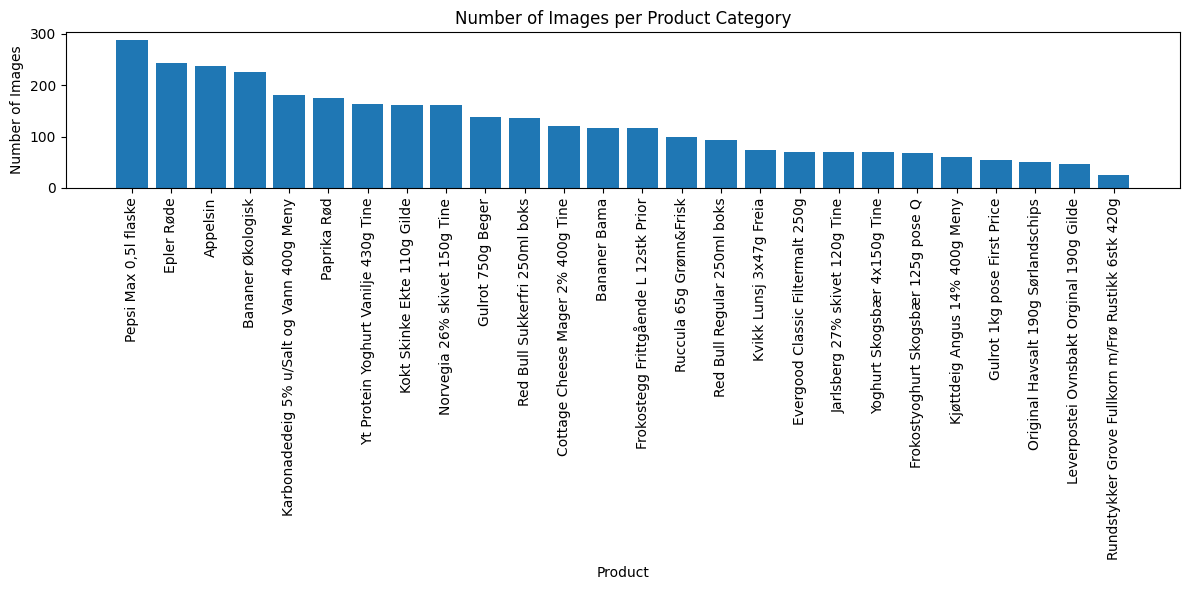

In [27]:
image_count_by_category = []

# Gather statistics for each product category
for product in plu_mapping.keys():
    product_path = os.path.join(DATASET_PATH, product)
    
    if os.path.exists(product_path):
        # Count image files (excluding _bb.png files)
        images = [f for f in os.listdir(product_path) if f.endswith('.png') and not f.endswith('_bb.png')]
        image_count = len(images)
        
        image_count_by_category.append({
            'PLU/GTIN': product,
            'Product Name': plu_mapping[product],
            'Image Count': image_count
        })

# Convert to DataFrame and sort by image count
stats_df = pd.DataFrame(image_count_by_category)
stats_df = stats_df.sort_values('Image Count', ascending=False)

# Display statistics
print(f"Total product categories: {len(stats_df)}")
print(f"Total images: {stats_df['Image Count'].sum()}")
print(f"Average images per category: {stats_df['Image Count'].mean():.1f}")
print(f"Median images per category: {stats_df['Image Count'].median():.1f}")
print(f"Max images per category: {stats_df['Image Count'].max()}")
print(f"Min images per category: {stats_df['Image Count'].min()}")

# Plot distribution of images across categories
plt.figure(figsize=(12, 6))
plt.bar(stats_df['Product Name'], stats_df['Image Count'])
plt.xticks(rotation=90)
plt.xlabel('Product')
plt.ylabel('Number of Images')
plt.title('Number of Images per Product Category')
plt.tight_layout()
plt.show()

## 4. Annotation Format

Let's examine the annotation format by looking at a sample annotation file:

In [29]:
sample_product = '4011'  # Bananas
sample_annotation_file = os.path.join(DATASET_PATH, sample_product, f"{sample_product}-19.txt")

with open(sample_annotation_file, 'r') as f:
    annotation_data = json.load(f)

print("Sample annotation content:")
print(json.dumps(annotation_data, indent=4))

Sample annotation content:
{
    "image": "4011-19.png",
    "image_details": [
        {
            "format": "png",
            "width": "480px",
            "height": "480px"
        }
    ],
    "label": [
        {
            "label": "4011",
            "topX": 0.24387505849202473,
            "topY": 0.4522510210673014,
            "bottomX": 0.6703025182088216,
            "bottomY": 0.8907889684041341
        }
    ]
}


The annotation contains:
- **image**: Filename of the image
- **image_details**: Image format and dimensions
- **label**: List of objects in the image with their bounding box coordinates
  - **label**: The PLU/GTIN code of the product
  - **topX, topY**: Top-left corner of the bounding box (normalized)
  - **bottomX, bottomY**: Bottom-right corner of the bounding box (normalized)

## 5. Sample Visualization

Let's visualize some random samples from the dataset:

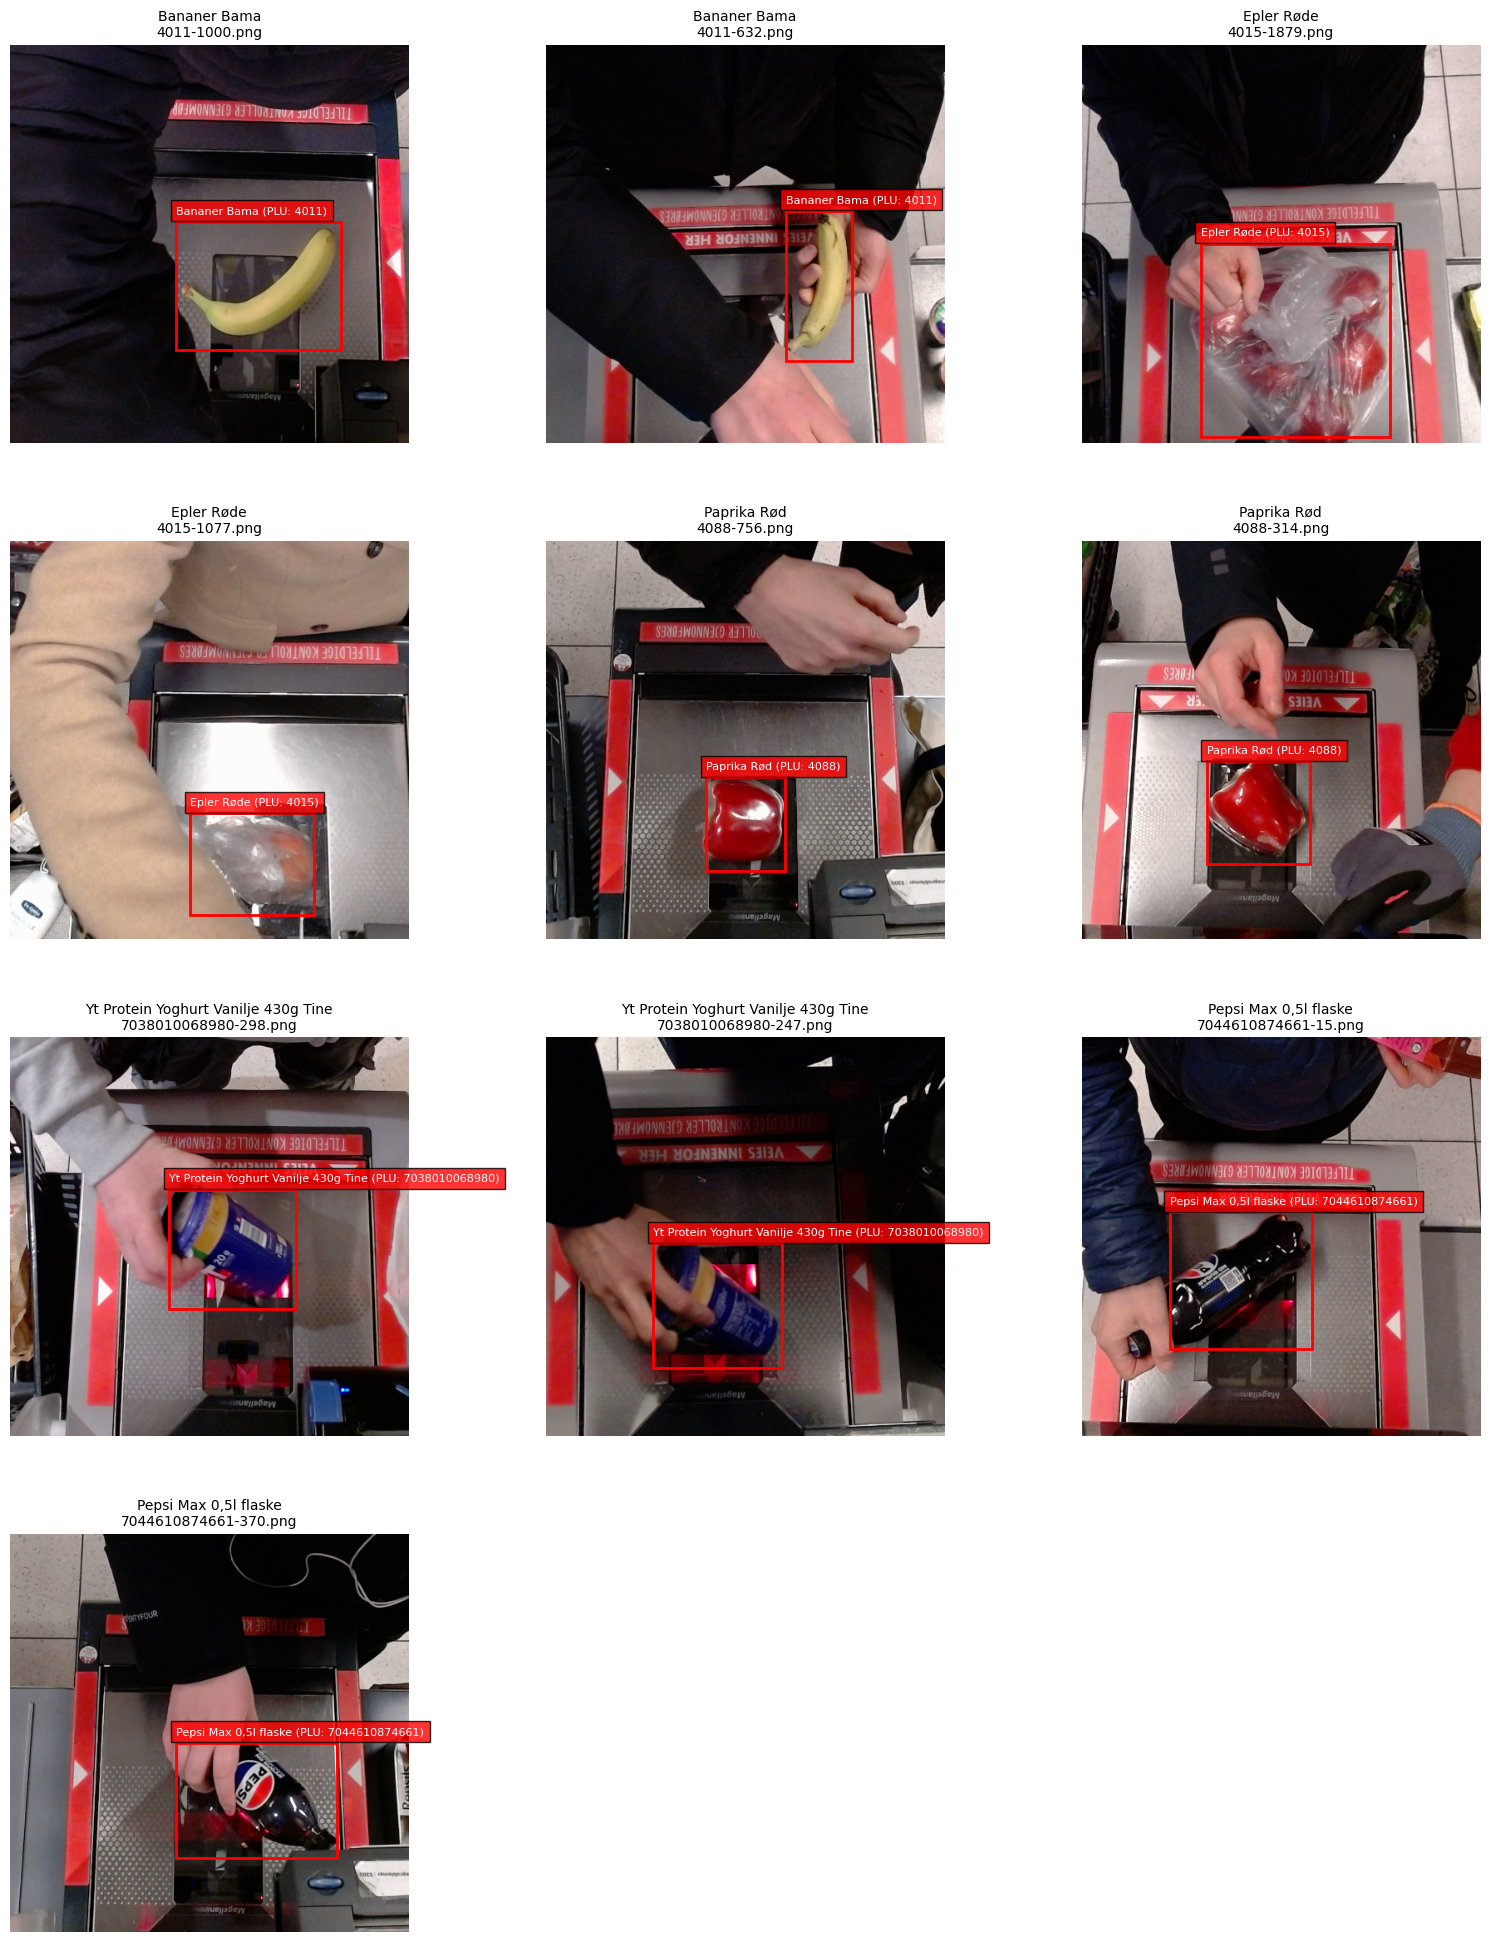

In [30]:
def visualize_sample_grid(product_ids, samples_per_product=2):
    """
    Visualizes sample images from different product categories in a grid.

    Args:
        product_ids (list): List of product IDs (PLU/GTIN codes) to visualize.
        samples_per_product (int): Number of sample images to display for each product.
    """
    num_products = len(product_ids)
    
    num_cols = 3  # You can adjust this based on your preference
    num_rows = (num_products * samples_per_product + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

    img_index = 0
    for product_id in product_ids:
        product_name = plu_mapping.get(product_id, product_id)
        product_path = os.path.join(DATASET_PATH, product_id)
    
        image_files = [f for f in os.listdir(product_path) if f.endswith('.png') and not f.endswith('_bb.png')]
    
        if not image_files:
            print(f"No images found for product {product_id}")
            continue
    
        samples = random.sample(image_files, min(samples_per_product, len(image_files)))

        for sample_image in samples:
            annotation_file = os.path.join(product_path, sample_image.replace('.png', '.txt'))
            try:
                img = Image.open(os.path.join(product_path, sample_image))
                with open(annotation_file, 'r') as f:
                    annotation = json.load(f)

                ax = axes[img_index]
                ax.imshow(img)
                
                width, height = img.size
    
                for obj in annotation['label']:
                    x1 = obj['topX'] * width
                    y1 = obj['topY'] * height
                    x2 = obj['bottomX'] * width
                    y2 = obj['bottomY'] * height
        
                    box_width = x2 - x1
                    box_height = y2 - y1
        
                    rect = Rectangle((x1, y1), box_width, box_height, 
                                     linewidth=2, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
        
                    product_name_label = plu_mapping.get(obj['label'], obj['label'])
                    ax.text(x1, y1-10, f"{product_name_label} (PLU: {obj['label']})", 
                             color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.8))
                
                ax.set_title(f"{product_name}\n{sample_image}", fontsize=10)
                ax.axis('off')
                img_index += 1

            except FileNotFoundError:
                print(f"Annotation file not found for {sample_image}")
            except Exception as e:
                print(f"Error processing {sample_image}: {e}")

    for i in range(img_index, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

sample_products = ['4011', '4015', '4088', '7038010068980', '7044610874661']
visualize_sample_grid(sample_products, samples_per_product=2)


## 6. Video Dataset and Challenge

In addition to the image dataset, there's also a video dataset for product scanning detection challenges. The videos are recordings from self-checkout registers at Meny Skøyen.

### The Video Challenge:

1. **Timestamp Detection**: The model must detect when a product is being scanned and identify the product.

2. **Comparison with Receipts**: The detected timestamps and products will be compared with actual receipts.

3. **Empty (Non-Scanned) Items**: Some receipts include items that weren't scanned - your model should identify these as well.

4. **Bonus - Theft Detection**: For advanced implementations, there are bonus points for detecting products that were not scanned at all (potential theft).

Let's check out a sample video frame to understand what we're working with:

Video FPS: 30.0
Total frames: 3675
Duration: 122.50 seconds (2.04 minutes)


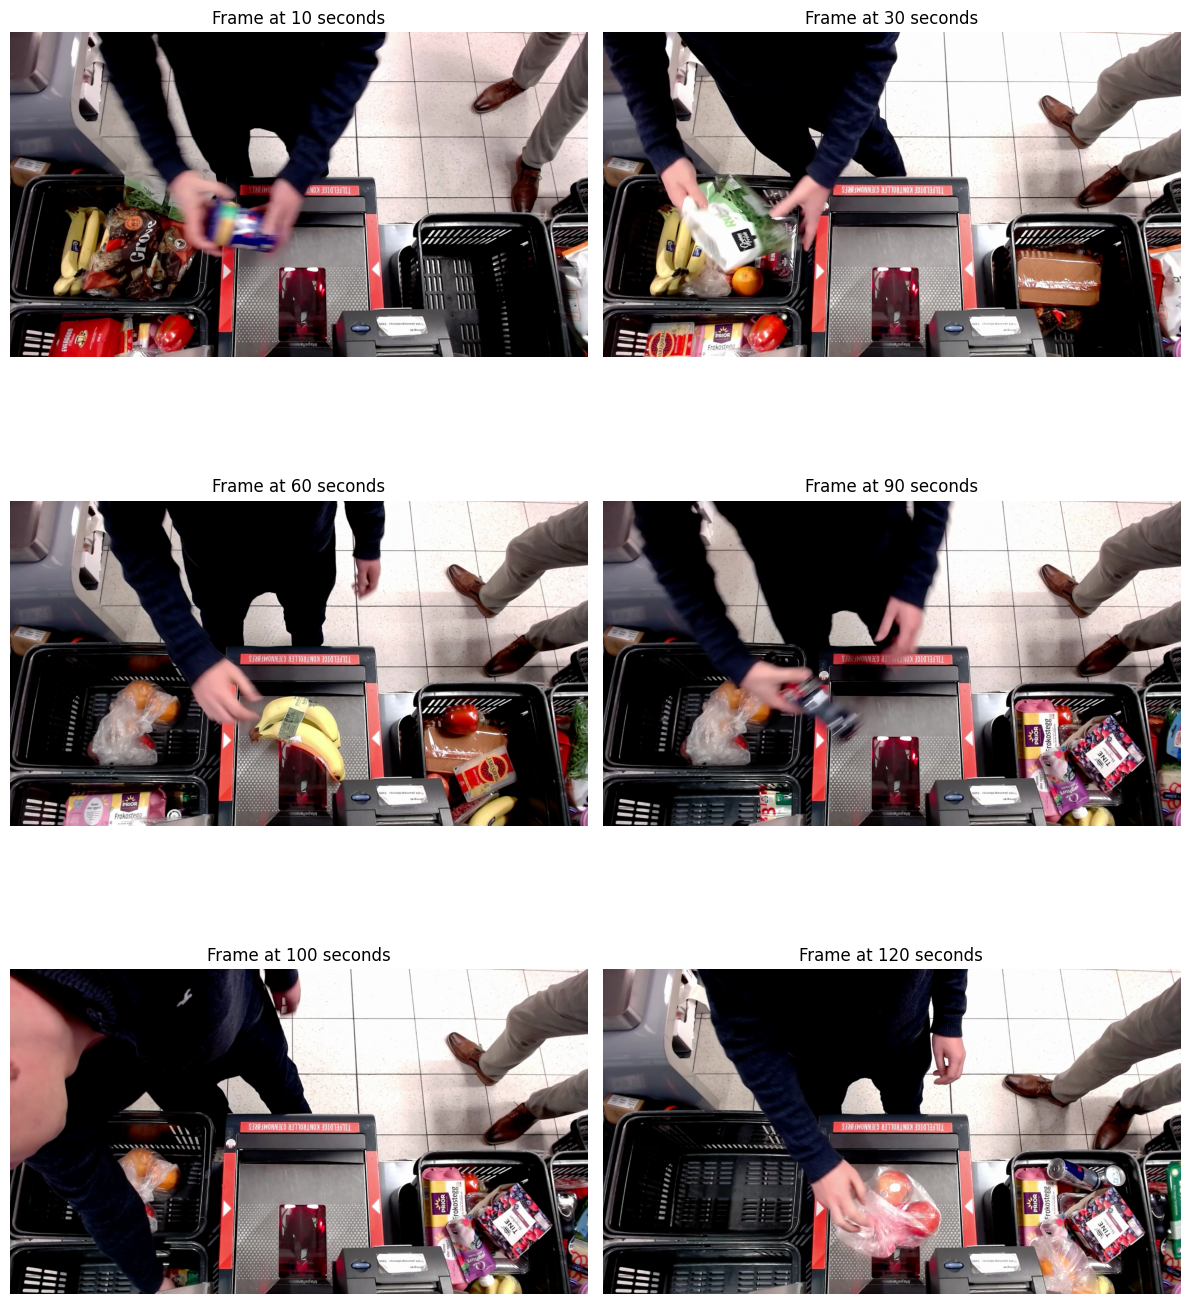

In [ ]:
try:
    video_path = 'video/Alle varer raskt tempo 720P.mp4'
    cap = cv2.VideoCapture(video_path)
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps
    
    print(f"Video FPS: {fps}")
    print(f"Total frames: {frame_count}")
    print(f"Duration: {duration:.2f} seconds ({duration/60:.2f} minutes)")
    
    sample_frames = []
    sample_times = [10, 30, 60, 90, 100, 120]
    
    for time_sec in sample_times:
        frame_pos = int(time_sec * fps)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)
        ret, frame = cap.read()
        
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            sample_frames.append((time_sec, frame_rgb))
    
    cap.release()
    
    num_frames = len(sample_frames)
    num_cols = 2
    num_rows = (num_frames + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5 * num_rows))
    axes = axes.flatten()
    
    for i, (time_sec, frame) in enumerate(sample_frames):
        ax = axes[i]
        ax.imshow(frame)
        ax.set_title(f"Frame at {time_sec} seconds")
        ax.axis('off')
    
    for i in range(num_frames, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

except ImportError:
    print("OpenCV (cv2) not installed. Install it with 'pip install opencv-python' to extract video frames.")
except Exception as e:
    print(f"Error processing video: {e}")


# Happy hacking! 🚀